In [2]:
import numpy as np
import pandas as pd
import sys 
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from patsy import dmatrices
import datetime as dtm

In [5]:
#definition to load the data
def load_data(data_dir, filenames):
    dataframes = {}
    #filenames = ['game_skater_stats',]
    for filename in filenames:
        dataframes[filename] = pd.read_csv(data_dir+filename+'.csv')
        #print('{}.csv read to dataframes'.format(filename))
    return dataframes

In [6]:
filenames = ['game_plays', 'game_plays_players', 'game',
            'game_teams_stats', 'game_shifts' ,'game_skater_stats'
            ,'game_goalie_stats' ,'team_info' ,'player_info']
data_dir = '~/Documents/Employment/Data_incubator/2019_application/Project/data/nhl-game-data/'
dataframes = load_data(data_dir, filenames)

# Expected goals modelling

In [7]:
#select only Forwards 
game_plays = dataframes['game_plays']
game_plays_players = dataframes['game_plays_players']

Text(-18, 32, 'p = 1.32e-29')

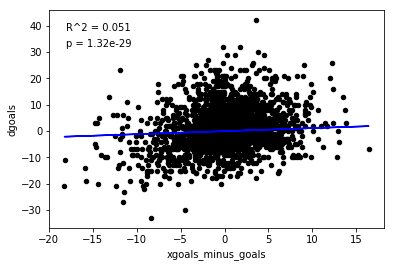

In [372]:
# naive xgoals = shots*league average shooting percentage
game_S_stats = dataframes['game_skater_stats']
player_info  = dataframes['player_info']
game = dataframes['game']
game_S_stats = pd.merge(game_S_stats, player_info, on='player_id')
game_S_stats = pd.merge(game_S_stats, game, on='game_id')
game_F_stats = game_S_stats[game_S_stats['primaryPosition']!='D']
season_agg = {'goals':'sum','shots':'sum','powerPlayGoals':'sum','timeOnIce':'sum'}
season_F_stats = game_F_stats.groupby(['player_id','season']).agg(season_agg)
season_F_stats = season_F_stats.reset_index()

#calculate naive xgoals
season_F_stats['xgoals'] = season_F_stats['shots'].apply(lambda x: gps*x+g0)
season_F_stats['xgoals_minus_goals'] = season_F_stats['xgoals'] - season_F_stats['goals']
#be careful about taking the right difference! pandas convention different than numpy
season_F_stats['dgoals'] = season_F_stats.groupby(['player_id'])['goals'].apply(lambda x: -x.diff(periods=-1))
season_F_stats = season_F_stats.dropna(subset=['dgoals'])#final seasons won't have dgoals



#how well does xgoals predict/correlate to season-to-season change in goals
slope, intercept, r, p, stderr = stats.linregress(season_F_stats['dgoals'],season_F_stats['xgoals_minus_goals'])
fig2, ax2 = plt.subplots(1)
season_F_stats.plot('xgoals_minus_goals', 'dgoals',kind='scatter',color='k',ax=ax2)
xgmg = season_F_stats['xgoals_minus_goals'].values
ax2.plot(xgmg, slope*xgmg+intercept,'b-')
plt.text(-18,38,'R^2 = {}'.format(round(r**2,-int(np.log10(r**2)-2))))
plt.text(-18,32,'p = {}'.format(round(p,-int(np.log10(p)-3))))


Text(0, 50, 'p = 0.0')

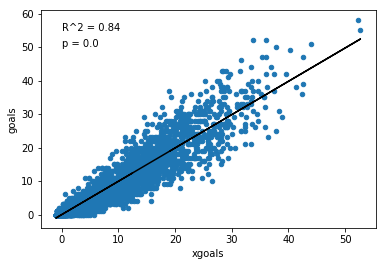

In [378]:
#how well does xgoals predict/correlate to goals?
slope, intercept, r, p, stderr = stats.linregress(season_F_stats['xgoals'],season_F_stats['goals'])
fig, ax = plt.subplots(1)
season_F_stats.plot('xgoals','goals',kind='scatter',ax=ax)
xgoals = season_F_stats['xgoals'].values
ax.plot(xgoals, slope*xgoals +intercept,'k')
plt.text(0,55,'R^2 = {}'.format(round(r**2,-int(np.log10(r**2)-2))))
plt.text(0,50,'p = {}'.format(p))

# Expected goals from spatially resolved shooting percentage 

In [355]:
#select data we want
game_plays = dataframes['game_plays']
game_plays_players = dataframes['game_plays_players']

#select shot events (from shooters, don't double count with goalie)
shot_events = ['Goal','Shot','Missed Shot']
game_plays = game_plays[game_plays['event'].isin(shot_events)]
game_plays = pd.merge(game_plays, game_plays_players[['play_id','player_id','playerType']],on='play_id')
game_plays = game_plays[game_plays['playerType'].isin(['Shooter','Scorer'])]
game_plays = pd.merge(game_plays,dataframes['game'][['game_id','season']],on='game_id')

#missed shots and saved shots  will be treated the same, neither went in
event_dict = {'Goal':1,'Shot':0,'Missed Shot':0}
game_plays['event'] = game_plays['event'].apply(lambda x: event_dict[x])

#drop data for which x, y coordinates are missing
game_plays = game_plays.dropna(subset = ['st_x','st_y'])

#prepare training datea
y, X = dmatrices('event ~ st_x + st_y-1', game_plays, return_type = 'dataframe')
y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .8)


In [246]:
#define and train the SVMs for a few hyperparameters
#this takes a long time and is quadratic in the size of the training set
start = time.time()
#sigma for the rbf kernels should be a few feet based on my hockey experience
gammas = {'10':1/(5**2), '5':1/(5**2), '2':1/(2)**2, 'auto':'auto'}
clfs = {}
for key in gammas.keys():
    gamma = gammas[key]
    clfs[key] = SVC(gamma=gamma,probability=True,class_weight='balanced')
    clfs[key].fit(X_train, y_train)
fit_time = (time.time()-start)/60
print(fit_time) 

342.1808815519015


In [360]:
#prepare a meshgrid with the spatially-resolved shooting percentage prediction for plotting
numx = 201 #size of 1/2 of the rink in feet
numy = 171
(xmin,xmax) = (0,100)
yrad = 45.5
x,y = np.meshgrid(np.linspace(xmin,xmax,numx),np.linspace(-yrad,yrad,numy))
z = {}
start = time.time()
for key in gammas.keys():
    z[key] = np.reshape(clfs[key].predict_proba(np.array([x.ravel(),y.ravel()]).T)[:,1],(numy,numx))
total = time.time() - start
print(total)
print(dtm.datetime.now())
print('done')

211.54267501831055
2019-02-03 18:05:09.073204
done


In [1]:
#plot the spatially-resolved shooting percentage for each hyperparameter
plotgammas = {}
fig, ax = plt.subplots(len(plotgammas.keys()))
i = 0
start = time.time()
for key in plotgammas.keys():
    ax[i].pcolormesh(x,y,z[key],shading='gouraud',cmap='Blues')
    i += 1
total = time.time() - start
print(total)
print(dtm.datetime.now())
print('done')

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'Spatially resolved shooting percentage')

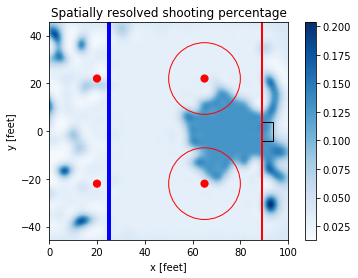

In [362]:
#plot the spatially-resolved shooting percentage for sigma=10, which gave the best R^2 to predict season-to-season change in goals
#annotate the plot properly so it's easy to interpret
fig, ax = plt.subplots(1)
cb = ax.pcolormesh(x,y,z['10'],shading='gouraud',cmap='Blues')#,norm=matplotlib.colors.LogNorm())
ax.set_xlabel('x [feet]')
ax.set_ylabel('y [feet]')
ax.set_aspect('equal')

#plot the rink
plt.axvline(x=25,color='b',linewidth=4)# blue line for offensive zone
plt.axvline(x=100-11,color='r',linewidth=2)# blue line for offensive zone
ax.add_patch(plt.Circle((65,22),15,color='r',fill=False))# faceoff circle
ax.add_patch(plt.Circle((65,-22),15,color='r',fill=False))# faceoff circle
ax.add_patch(plt.Circle((65,22),1.5,color='r',fill=True))# faceoff dot
ax.add_patch(plt.Circle((65,-22),1.5,color='r',fill=True))# faceoff dot
ax.add_patch(plt.Circle((20,22),1.5,color='r',fill=True))# faceoff dot
ax.add_patch(plt.Circle((20,-22),1.5,color='r',fill=True))# faceoff dot
goal_loc = matplotlib.patches.Rectangle((89,-4),4.5,8,color='k',fill=False)# the goal
ax.add_patch(goal_loc)#the goal
plt.colorbar(cb)#color bar so you can read the plot ~quantitatively
ax.set_title('Spatially resolved shooting percentage')

In [253]:
#calculate expected goals from each shot based on shot position using the learned models
#this takes a lot of time because there's a lot of data
#should take care not to use the training data in testing..
coords = np.array([game_plays['st_x'].values, game_plays['st_y'].values])
gprobs = {}
start = time.time()
for key in gammas.keys():
    gprobs[key] = clfs[key].predict_proba(coords.T)
total = time.time() - start
print(total)
print(dtm.datetime.now())
print('done')
#gprobs = clf10.predict_proba(coords.T)

3755.367402076721
2019-02-03 10:12:46.747191
done


In [363]:
#Write expected goals to dataframe
game_plays['xgoals'] =  gprobs['10'].T[1]
game_plays.head()
season_player = game_plays.groupby(['player_id','season']).agg({'event':{'shots':'count','goals':'sum'},'xgoals':'sum'})
season_player.columns = ['shots', 'goals', 'xgoals']
season_player = season_player.reset_index()
season_player['dgoals'] = season_player.groupby(['player_id'])['goals'].apply(lambda x: -x.diff(periods=-1))
season_player = season_player.dropna(subset = ['dgoals'])
season_player['xgmg'] = season_player['xgoals']- season_player['goals']
season_player.plot('xgmg','dgoals',kind='scatter',ax=ax2)


#regression of season-to-season goal change vs xgoals - goals
slope, intercept, r, p, stderr = stats.linregress(season_player['dgoals'].values, season_player['xgmg'].values)
print((r**2,p))

/Users/tiwariku/anaconda/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


(0.0848178799740479, 3.3290101879230535e-72)


Text(8, 32, 'p = 3.33e-72')

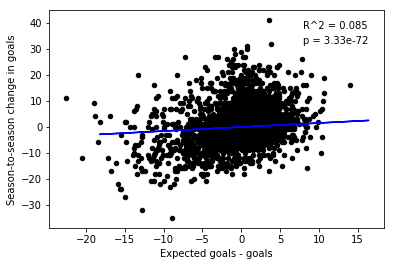

In [367]:
#season_F_stats.plot('xgoals','goals',kind='scatter')

fig2, ax2 = plt.subplots(1)
ax2.plot(xgmg, slope*xgmg+intercept,'b-')
season_player.plot('xgmg','dgoals',kind='scatter',color='k',ax=ax2)
ax2.set_xlabel('Expected goals - goals')
ax2.set_ylabel('Season-to-season change in goals')
plt.text(8,38,'R^2 = {}'.format(round(r**2,-int(np.log10(r**2)-2))))
plt.text(8,32,'p = {}'.format(round(p,-int(np.log10(p)-3))))

Text(0, 50, 'p = 0.0')

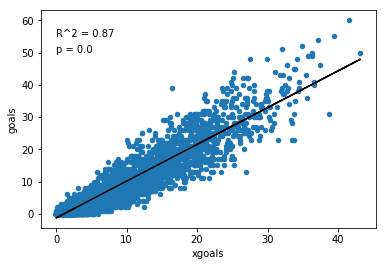

In [377]:
#how well does xgoals predict/correlate to goals?
slope, intercept, r, p, stderr = stats.linregress(season_player['xgoals'],season_player['goals'])
fig, ax = plt.subplots(1)
season_player.plot('xgoals','goals',kind='scatter',ax=ax)
xgoals = season_player['xgoals'].values
ax.plot(xgoals, slope*xgoals +intercept,'k')
plt.text(0,55,'R^2 = {}'.format(round(r**2,-int(np.log10(r**2)-2))))
plt.text(0,50,'p = {}'.format(p))

# Appendix: rough exploratory analysis. Everything below here is poorly commented

In [132]:
#Exploratory analysis

game_cut = dataframes['game'][['game_id', "date_time",'season', 'type']]#to calculate player age
game_cut = game_cut[game_cut['type']=='R'][['game_id','date_time','season']]#remove playoffs
player_info_cut = dataframes['player_info'][['player_id','birthDate','primaryPosition','firstName','lastName']]#to calculate player age
game_skater_stats = dataframes['game_skater_stats']#[['game_id','player_id','goals','assists','shots','timeOnIce','hits']]
game_skater_stats = game_skater_stats.set_index('game_id').join(game_cut.set_index('game_id'))

game_skater_stats['season'] = game_skater_stats['season']%10000#get the year of the season
game_skater_stats = game_skater_stats.set_index('player_id').join(player_info_cut.set_index('player_id'))#

game_skater_stats['birthDate'] = pd.to_datetime(game_skater_stats['birthDate'],utc=True)
game_skater_stats['date_time'] = pd.to_datetime(game_skater_stats['date_time'],utc=True)
game_skater_stats['age'] = (game_skater_stats['date_time'] - game_skater_stats['birthDate']).dt.days/365 
agg_dict= {'goals':np.sum,'assists':np.sum,'shots':np.sum,'timeOnIce':np.sum,'hits':np.sum,'age':np.mean}
group_by_keys = ['player_id','firstName','lastName','season','primaryPosition']

season_skater_stats = game_skater_stats.groupby(group_by_keys).agg(agg_dict)
season_skater_stats.reset_index()
season_skater_stats['dgoals'] = season_skater_stats.groupby(['player_id'])['goals'].apply(lambda x: x.diff())
season_skater_stats['dshots'] = season_skater_stats.groupby(['player_id'])['shots'].apply(lambda x: x.diff())
season_skater_stats['cTOI'] = season_skater_stats.groupby(['player_id'])['timeOnIce'].apply(lambda x: x.cumsum())
season_skater_stats['chits'] = season_skater_stats.groupby(['player_id'])['hits'].apply(lambda x: x.cumsum())
season_skater_stats['gps'] = season_skater_stats['goals']/season_skater_stats['shots']
season_skater_stats = season_skater_stats.reset_index()

season_defence_stats = season_skater_stats[season_skater_stats['primaryPosition']=='D']
season_forward_stats = season_skater_stats[season_skater_stats['primaryPosition']!='D']


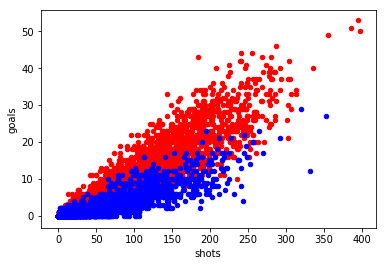

In [133]:
fig, ax = plt.subplots()
season_forward_stats.plot('shots','goals',kind='scatter',ax=ax,color='r')
season_defence_stats.plot('shots','goals',kind='scatter',ax=ax,color='b')

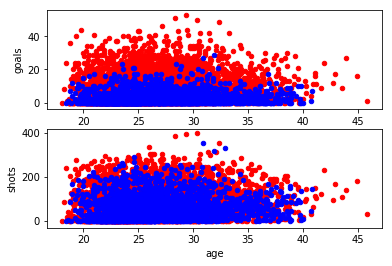

In [134]:
fig, ax = plt.subplots(2)
season_forward_stats.plot('age','goals',kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot('age','goals',kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot('age','shots',kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot('age','shots',kind='scatter',ax=ax[1],color='b')



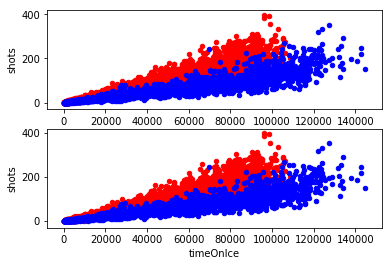

In [135]:
fig, ax = plt.subplots(2)
xkey = 'timeOnIce'
ykey1 = 'shots'
ykey2 = 'assists'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[1],color='b')

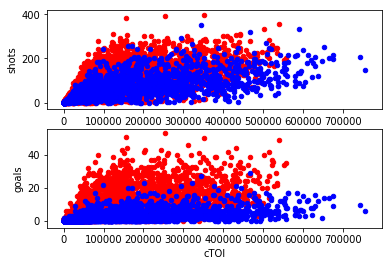

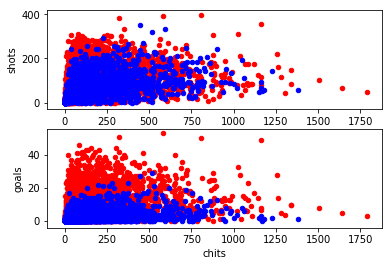

In [136]:
fig, ax = plt.subplots(2)
xkey = 'cTOI'
ykey1 = 'shots'
ykey2 = 'goals'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='b')
fig, ax = plt.subplots(2)
xkey = 'chits'
ykey1 = 'shots'
ykey2 = 'goals'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='b')

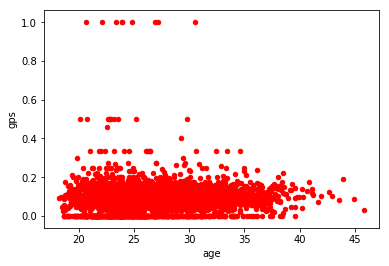

In [137]:
fig, ax = plt.subplots(1)
season_forward_stats.plot('age','gps',kind='scatter',ax=ax,color='r')

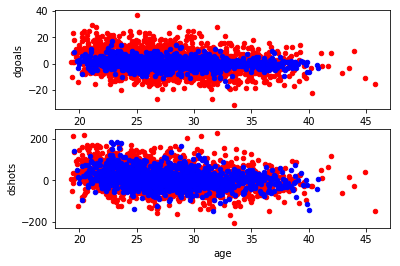

In [139]:
fig, ax = plt.subplots(2)
xkey = 'age'
ykey1 = 'dgoals'
ykey2 = 'dshots'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='b')

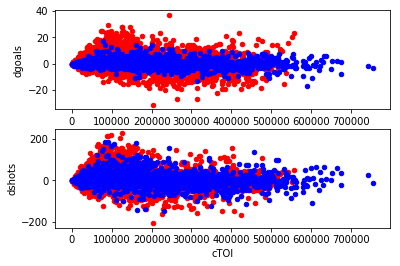

In [141]:
fig, ax = plt.subplots(2)
xkey = 'cTOI'
ykey1 = 'dgoals'
ykey2 = 'dshots'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='b')

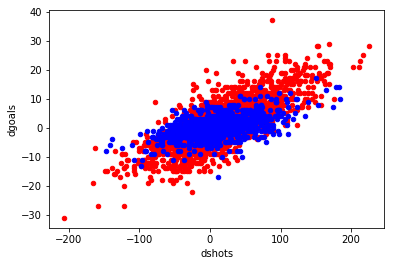

In [144]:
fig, ax = plt.subplots(1)
xkey = 'dshots'
ykey1 = 'dgoals'
ykey2 = 'dshots'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax,color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax,color='b')

In [14]:
#feature expansion to shot angle and shot distance
goal_x, goal_y = 89, 0 #location of the goal
goal_y = 0
game_plays['shot_r'] = (((game_plays['st_x']-goal_x).apply(np.square)+(game_plays['st_y']-goal_y).apply(np.square)).apply(np.sqrt))
game_plays['shot_phi'] = ((goal_x-game_plays['st_x'] + 1j*game_plays['st_y']).apply(np.angle)).apply(np.abs)


In [240]:
#logistic regression to predict shot quality, didn't work well/work in progress
#need to think more about feature expansion
#feature expansion to shot angle and shot distance
goal_x, goal_y = 89, 0 #location of the goal
game_plays['shot_r'] = (((game_plays['st_x']-goal_x).apply(np.square)+(game_plays['st_y']-goal_y).apply(np.square)).apply(np.sqrt))
game_plays['shot_phi'] = ((goal_x-game_plays['st_x'] + 1j*game_plays['st_y']).apply(np.angle)).apply(np.abs)

#prepare training datea
y, X = dmatrices('event ~ st_x + st_y-1', game_plays, return_type = 'dataframe')
y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .8)

model = LogisticRegression()
model = model.fit(X_train, y_train)
model.score(X,y), 1-y.mean()

Index(['st_x', 'st_y'], dtype='object')


/Users/tiwariku/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.9333975745192385, 0.9333975745192385)

In [39]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,st_x,[0.004974446787892968]
1,st_y,[-0.0011189725853361608]
